,case,peak_total,peak_L1,peak_L0A,peak_L0B,peak_L0C,COPY_IN,COPY_OUT,MOVE,COMPUTE_ops
0,Conv_Case0,15088,12432,0,2656,0,303,7,300,308
1,Conv_Case1,53448,13896,0,39552,0,1353,47,5330,5330
2,FlashAttention_Case0,10240,3328,1920,1920,3072,24,16,128,404
3,FlashAttention_Case1,27904,5376,6400,6400,9728,48,32,512,1704
4,Matmul_Case0,28928,9216,8576,8576,2560,128,64,1024,512
5,Matmul_Case1,191232,34816,73472,73472,9472,512,256,8192,4096


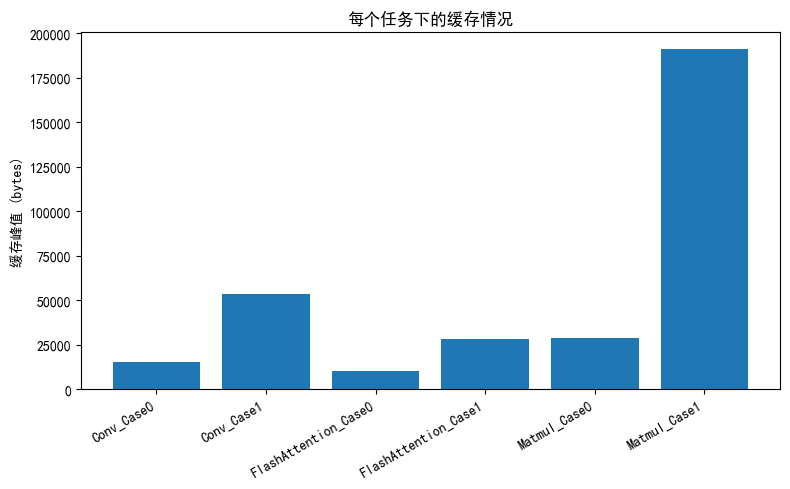

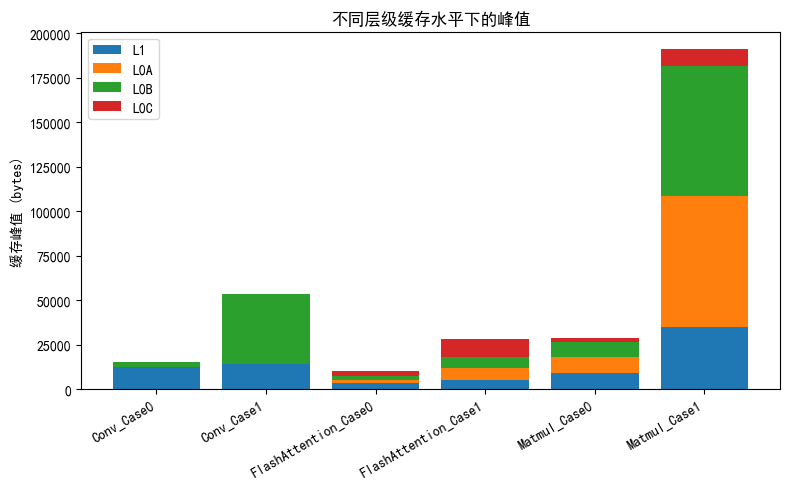

C:\Users\zimin\AppData\Local\Temp\ipykernel_10260\895254563.py:212: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cases_order, showfliers=False)


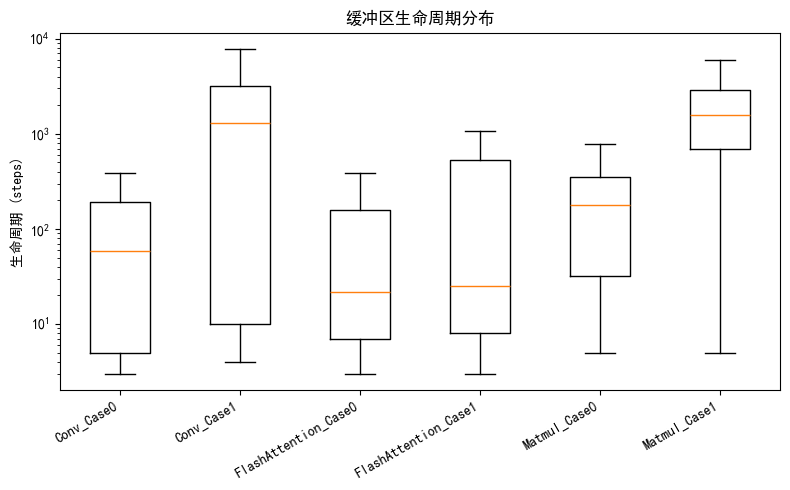

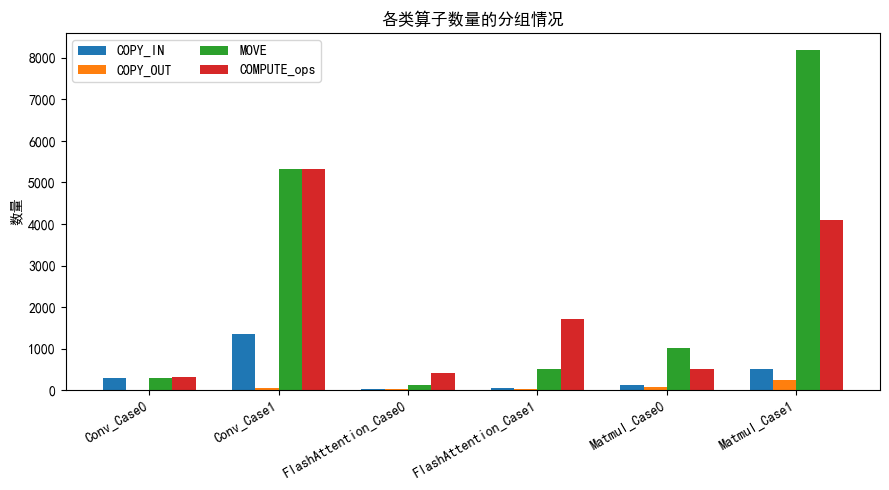

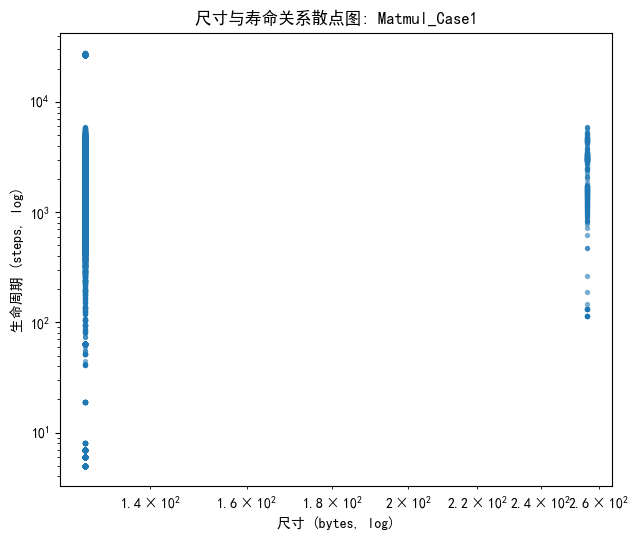


生成文件保存在： D:\code\数学建模2025\重跑\plots
包括：plots_summary_metrics.csv、5张PNG图。


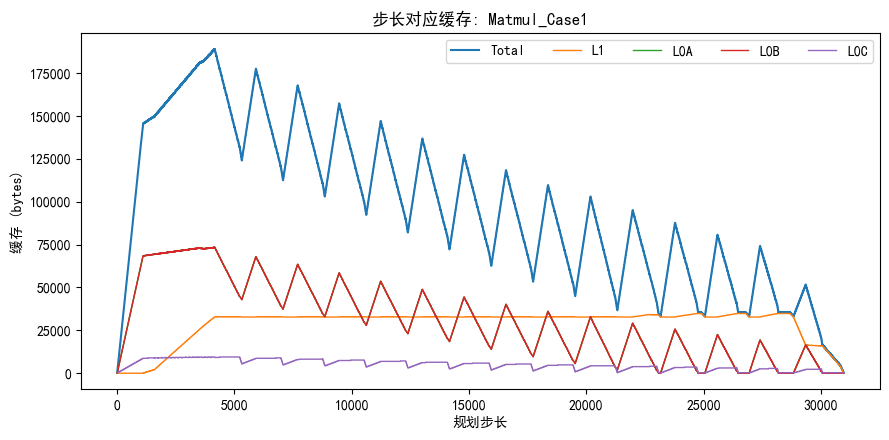

In [1]:
# -*- coding: utf-8 -*-
# 绘图依赖：matplotlib（不要装 seaborn）
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

# ============= 配置区 =============
# 你的数据所在目录：在本对话环境里是 /mnt/data
BASE_DIR = Path("./A1")  # 如在本地运行，可改成 Path(".") 或你的绝对路径
# 如需自动扫描，可保留 DEFAULT_CASES；否则手动列出
DEFAULT_CASES = [
    "Conv_Case0", "Conv_Case1",
    "Matmul_Case0", "Matmul_Case1",
    "FlashAttention_Case0", "FlashAttention_Case1"
]

# 输出图片与汇总 CSV 的目录
OUT_DIR = Path("./plots"); OUT_DIR.mkdir(exist_ok=True)

# ============= 工具函数 =============
def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

def pick(df: pd.DataFrame, names):
    """在多种可能命名中匹配一列名；若完全匹配失败，再做包含匹配。"""
    names = [n.lower() for n in names]
    for n in names:
        if n in df.columns:
            return n
    for c in df.columns:
        for n in names:
            if n in c:
                return c
    raise KeyError(f"None of {names} found in columns: {df.columns.tolist()}")

def load_case(case_name: str, base: Path):
    nodes = normalize_cols(pd.read_csv(base / f"{case_name}_node_attributes.csv"))
    sched = normalize_cols(pd.read_csv(base / f"{case_name}_schedule_final.csv"))
    life  = normalize_cols(pd.read_csv(base / f"{case_name}_buf_lifecycle.csv"))
    return nodes, sched, life

def schedule_pos_map(sched: pd.DataFrame):
    node_col = pick(sched, ["nodeid","id","node_id"])
    order = sched[node_col].tolist()
    return {int(n): i for i, n in enumerate(order)}

def compute_peaks_and_lifetimes(nodes, sched, life):
    """返回：分层峰值字典 & 含 size/lifetime 的 life2 表"""
    id_col    = pick(nodes, ["id","nodeid","node_id"])
    op_col    = pick(nodes, ["op","opcode","operation"])
    buf_col   = pick(nodes, ["bufid","buf_id","buffer","buffer_id"])
    size_col  = pick(nodes, ["size","bytes"])
    cache_col = pick(nodes, ["type","cache_type","level","cachelevel"])

    alloc_nodes = nodes[nodes[op_col].str.upper()=="ALLOC"].copy()
    alloc_nodes[buf_col] = alloc_nodes[buf_col].astype(int)
    buf_map = (alloc_nodes
               .set_index(buf_col)[[size_col, cache_col, id_col]]
               .rename(columns={size_col:"size", cache_col:"cache", id_col:"alloc_node"}))

    pos = schedule_pos_map(sched)

    life_buf  = pick(life, ["bufid","buf_id"])
    life_alloc= pick(life, ["allocnode","alloc_node"])
    life_free = pick(life, ["freenode","free_node"])

    life2 = life.copy()
    life2[life_buf] = life2[life_buf].astype(int)
    life2["alloc_idx"] = life2[life_alloc].astype(int).map(pos)
    life2["free_idx"]  = life2[life_free].astype(int).map(pos)
    life2 = life2.merge(buf_map, left_on=life_buf, right_index=True, how="left")

    # 事件扫描计算分层峰值
    events = {}
    for _, r in life2.iterrows():
        size = int(r["size"]) if pd.notna(r["size"]) else 0
        cache = str(r["cache"]) if pd.notna(r["cache"]) else "NA"
        ai = int(r["alloc_idx"]); fi = int(r["free_idx"])
        events.setdefault(cache, []).append((ai, +size))
        events.setdefault(cache, []).append((fi + 1e-6, -size))  # epsilon 让释放晚于同步点的分配

    peaks = {}
    for cache, evs in events.items():
        evs.sort(key=lambda x: x[0])
        cur = 0; peak = 0
        for _, delta in evs:
            cur += delta
            if cur > peak:
                peak = cur
        peaks[cache] = int(peak)

    # 缓冲区寿命（步数）
    life2["lifetime_steps"] = life2["free_idx"] - life2["alloc_idx"] + 1
    return peaks, life2

def compute_op_counts(nodes):
    op_col = pick(nodes, ["op","opcode","operation"])
    ops = nodes[op_col].str.upper().value_counts().to_dict()
    exclude = {"ALLOC","FREE","COPY_IN","COPY_OUT","MOVE"}
    compute_ops = sum(cnt for k, cnt in ops.items() if k not in exclude)
    return {"COPY_IN": ops.get("COPY_IN",0),
            "COPY_OUT": ops.get("COPY_OUT",0),
            "MOVE": ops.get("MOVE",0),
            "COMPUTE_ops": compute_ops}

def residency_curve_by_level(nodes, sched, life):
    """可选：生成‘驻留随步数曲线’（总量与分层）。返回 steps, total, {level: curve}"""
    peaks, life2 = compute_peaks_and_lifetimes(nodes, sched, life)
    pos = schedule_pos_map(sched)
    T = len(pos)  # 以调度步为横轴
    levels = ["L1","L0A","L0B","L0C"]
    curves = {lv: np.zeros(T, dtype=np.int64) for lv in levels}
    total  = np.zeros(T, dtype=np.int64)

    for _, r in life2.iterrows():
        sz = int(r["size"]) if pd.notna(r["size"]) else 0
        if sz <= 0: continue
        ai = int(r["alloc_idx"]); fi = int(r["free_idx"])
        cache = str(r["cache"]) if pd.notna(r["cache"]) else "NA"
        sl = slice(ai, fi+1)
        total[sl] += sz
        if cache in curves:
            curves[cache][sl] += sz
    steps = np.arange(T)
    return steps, total, curves

# ============= 读取数据 & 计算指标 =============
cases = [c for c in DEFAULT_CASES
         if (BASE_DIR / f"{c}_node_attributes.csv").exists()
         and (BASE_DIR / f"{c}_schedule_final.csv").exists()
         and (BASE_DIR / f"{c}_buf_lifecycle.csv").exists()]

if not cases:
    raise FileNotFoundError(f"未在 {BASE_DIR} 找到任何目标案例文件，请检查路径或文件命名。")

summary_rows = []
lifetimes_by_case = {}
size_life_scatter = {}

for case in sorted(cases):
    nodes, sched, life = load_case(case, BASE_DIR)
    peaks, life2 = compute_peaks_and_lifetimes(nodes, sched, life)
    counts = compute_op_counts(nodes)

    peak_L1  = peaks.get("L1",0)
    peak_L0A = peaks.get("L0A",0)
    peak_L0B = peaks.get("L0B",0)
    peak_L0C = peaks.get("L0C",0)
    peak_total = peak_L1 + peak_L0A + peak_L0B + peak_L0C

    lifetimes_by_case[case] = life2["lifetime_steps"].dropna().astype(int).values
    size_life_scatter[case] = life2[["size","lifetime_steps"]].dropna().astype(float).values

    summary_rows.append({
        "case": case,
        "peak_total": peak_total,
        "peak_L1": peak_L1,
        "peak_L0A": peak_L0A,
        "peak_L0B": peak_L0B,
        "peak_L0C": peak_L0C,
        **counts
    })

summary = pd.DataFrame(summary_rows).sort_values("case").reset_index(drop=True)
summary.to_csv(OUT_DIR / "plots_summary_metrics.csv", index=False)
display(summary)

# ============= 绘图（论文可用基础版） =============
# 注意：按平台要求，图表使用 matplotlib；每张图单独画布；不指定颜色风格。

# 图1：各案例峰值总驻留量
plt.figure(figsize=(8,5))
plt.bar(summary["case"], summary["peak_total"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("缓存峰值 (bytes)")
plt.title("每个任务下的缓存情况")
plt.tight_layout()
plt.savefig(OUT_DIR / "plot_peak_total_by_case.png", dpi=200)
plt.show()

# 图2：按缓存层分解的峰值堆叠柱状
cases_order = summary["case"].tolist()
L1  = summary.set_index("case").loc[cases_order, "peak_L1"].values
L0A = summary.set_index("case").loc[cases_order, "peak_L0A"].values
L0B = summary.set_index("case").loc[cases_order, "peak_L0B"].values
L0C = summary.set_index("case").loc[cases_order, "peak_L0C"].values

plt.figure(figsize=(8,5))
b1 = plt.bar(cases_order, L1, label="L1")
b2 = plt.bar(cases_order, L0A, bottom=L1, label="L0A")
b3 = plt.bar(cases_order, L0B, bottom=L1+L0A, label="L0B")
b4 = plt.bar(cases_order, L0C, bottom=L1+L0A+L0B, label="L0C")
plt.xticks(rotation=30, ha="right")
plt.ylabel("缓存峰值 (bytes)")
plt.title("不同层级缓存水平下的峰值")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "plot_stacked_peaks_by_cache.png", dpi=200)
plt.show()

# 图3：缓冲区生命周期分布（箱线图，log 纵轴）
data = [lifetimes_by_case[c] for c in cases_order]
plt.figure(figsize=(8,5))
plt.boxplot(data, labels=cases_order, showfliers=False)
plt.yscale("log")
plt.ylabel("生命周期 (steps)")
plt.title("缓冲区生命周期分布")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(OUT_DIR / "plot_lifetime_boxplot.png", dpi=200)
plt.show()

# 图4：算子组成（分组柱状）
cols = ["COPY_IN","COPY_OUT","MOVE","COMPUTE_ops"]
x = np.arange(len(cases_order)); width = 0.18
plt.figure(figsize=(9,5))
for i, col in enumerate(cols):
    plt.bar(x + i*width - 1.5*width,
            summary.set_index("case").loc[cases_order, col].values,
            width, label=col)
plt.xticks(x, cases_order, rotation=30, ha="right")
plt.ylabel("数量")
plt.title("各类算子数量的分组情况")
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig(OUT_DIR / "plot_op_counts_grouped.png", dpi=200)
plt.show()

# 图5：尺寸-寿命散点（双对数），默认 Matmul_Case1 为代表
rep = "Matmul_Case1" if "Matmul_Case1" in size_life_scatter else cases_order[-1]
xy = size_life_scatter[rep]
if len(xy) > 0:
    plt.figure(figsize=(6.5,5.5))
    plt.scatter(xy[:,0], xy[:,1], s=8, alpha=0.5)
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("尺寸 (bytes, log)")
    plt.ylabel("生命周期 (steps, log)")
    plt.title(f"尺寸与寿命关系散点图: {rep}")
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"plot_size_vs_lifetime_{rep}.png", dpi=200)
    plt.show()
else:
    print(f"[提示] {rep} 无有效 size-lifetime 数据，跳过散点图。")

print("\n生成文件保存在：", OUT_DIR.resolve())
print("包括：plots_summary_metrics.csv、5张PNG图。")

# ============= 可选：驻留随步数曲线（开启下方代码块） =============
case_to_draw = "Matmul_Case1"  # 可改成其它案例名
nodes, sched, life = load_case(case_to_draw, BASE_DIR)
steps, total, curves = residency_curve_by_level(nodes, sched, life)
plt.figure(figsize=(9,4.5))
plt.plot(steps, total, label="Total")
for lv, arr in curves.items():
    if arr.sum() > 0:
        plt.plot(steps, arr, label=lv, linewidth=1)
plt.xlabel("规划步长"); plt.ylabel("缓存 (bytes)")
plt.title(f"步长对应缓存: {case_to_draw}")
plt.legend(ncol=5)
plt.tight_layout()
plt.savefig(OUT_DIR / f"plot_residency_curve_{case_to_draw}.png", dpi=200)
plt.show()


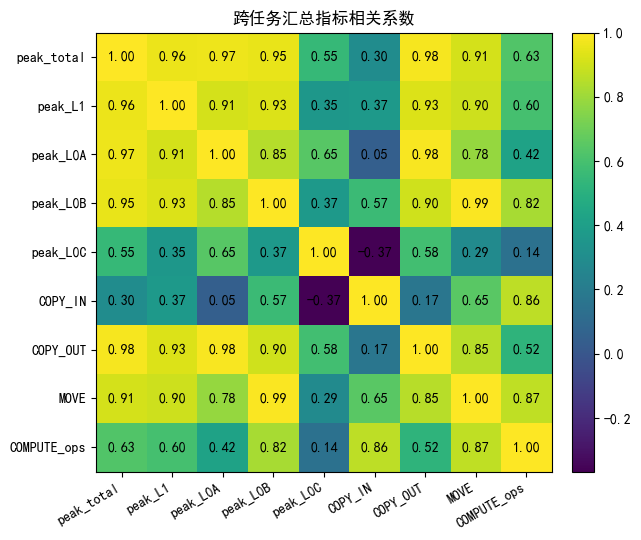

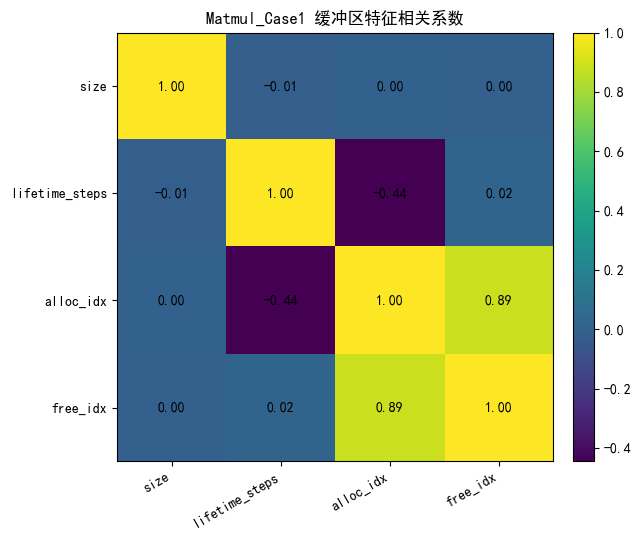

In [2]:
# ================= 相关系数热力图 =================
# 说明：仅用 matplotlib；不依赖 seaborn；自动筛选数值列并计算 Pearson 相关系数

def plot_corr_heatmap(df: pd.DataFrame, title: str, outfile: Path):
    """对 df 的数值列做相关系数矩阵，并画成热力图"""
    num = df.select_dtypes(include=[np.number])
    if num.shape[1] < 2:
        print("[提示] 可用于相关性的数值列少于2，跳过绘图。")
        return
    corr = num.corr(method="pearson")

    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    im = ax.imshow(corr, aspect="auto", interpolation="nearest")  # 默认配色，不手动指定
    ax.set_title(title)

    # 坐标轴刻度与标签
    ax.set_xticks(np.arange(corr.shape[1]))
    ax.set_xticklabels(corr.columns, rotation=30, ha="right")
    ax.set_yticks(np.arange(corr.shape[0]))
    ax.set_yticklabels(corr.index)

    # 数值标注
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center")

    # 颜色条
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    plt.savefig(outfile, dpi=200)
    plt.show()

# 1) 跨任务“汇总指标”的相关性（来源：summary）
plot_corr_heatmap(
    df=summary, 
    title="跨任务汇总指标相关系数",
    outfile=OUT_DIR / "heatmap_corr_summary.png"
)

# 2) 单个任务的“缓冲区特征”相关性（size / lifetime / alloc_idx / free_idx）
def per_case_corr_heatmap(case_name: str):
    nodes, sched, life = load_case(case_name, BASE_DIR)
    _, life2 = compute_peaks_and_lifetimes(nodes, sched, life)
    df_case = life2[["size", "lifetime_steps", "alloc_idx", "free_idx"]].dropna()
    if len(df_case) < 3:
        print(f"[提示] {case_name} 有效样本不足，跳过。")
        return
    plot_corr_heatmap(
        df=df_case,
        title=f"{case_name} 缓冲区特征相关系数",
        outfile=OUT_DIR / f"heatmap_corr_{case_name}.png"
    )

# 指定一个代表性任务输出热力图（可改成你想看的案例名）
per_case_corr_heatmap("Matmul_Case1")


汇总表已保存: ./plots_problem1_data\problem1_data_summary.csv


,case,nodes,edges,alloc,free,unique_bufid,alloc_size_sum,alloc_size_min,alloc_size_max,alloc_size_median,alloc_size_p90,alloc_size_mean
0,Conv_Case0,2580,3869,831,831,831,150807,1,1536,72.0,384.0,181.477
1,Conv_Case1,36086,85653,12013,12013,12013,570168,1,256,64.0,72.0,47.463
2,FlashAttention_Case0,1716,2712,572,572,572,64264,2,256,128.0,256.0,112.350
3,FlashAttention_Case1,6952,11184,2328,2328,2328,248976,2,256,128.0,256.0,106.948
4,Matmul_Case0,4160,7104,1216,1216,1216,163840,128,256,128.0,128.0,134.737
5,Matmul_Case1,30976,55040,8960,8960,8960,1179648,128,256,128.0,128.0,131.657


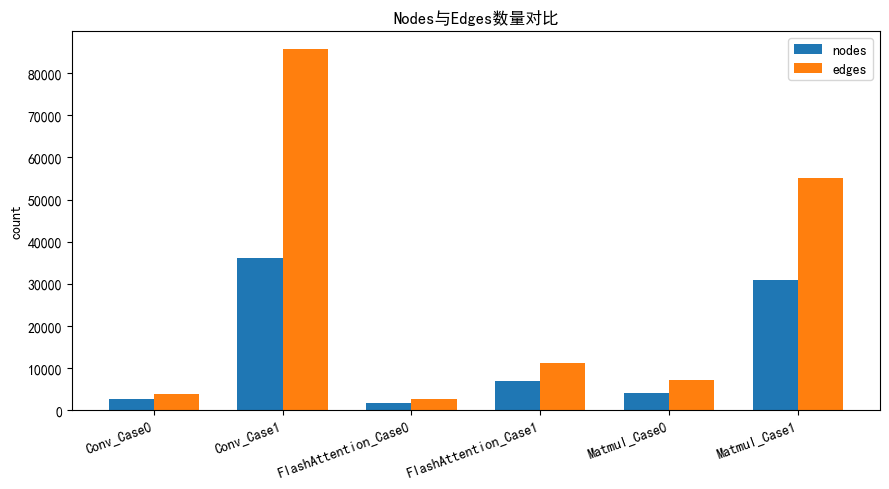

保存: ./plots_problem1_data\desc_plot_nodes_edges.png


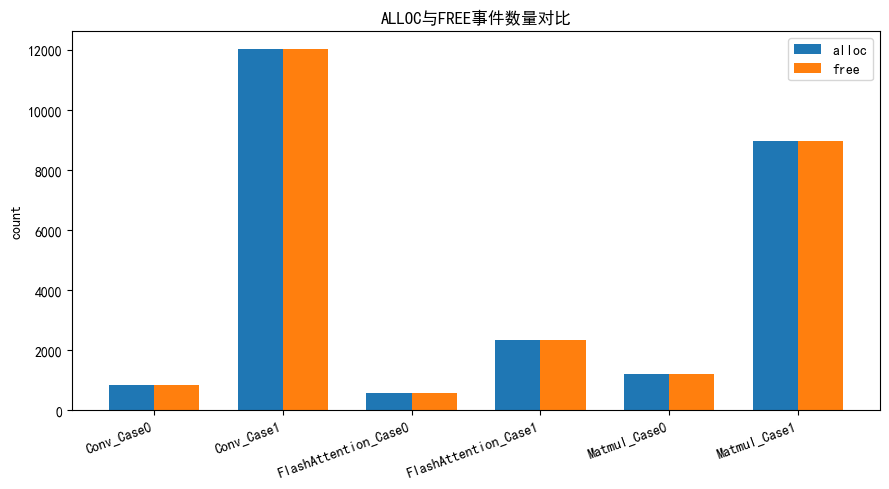

保存: ./plots_problem1_data\desc_plot_alloc_free.png


C:\Users\zimin\AppData\Local\Temp\ipykernel_10260\4195675393.py:184: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=labels, showmeans=True)


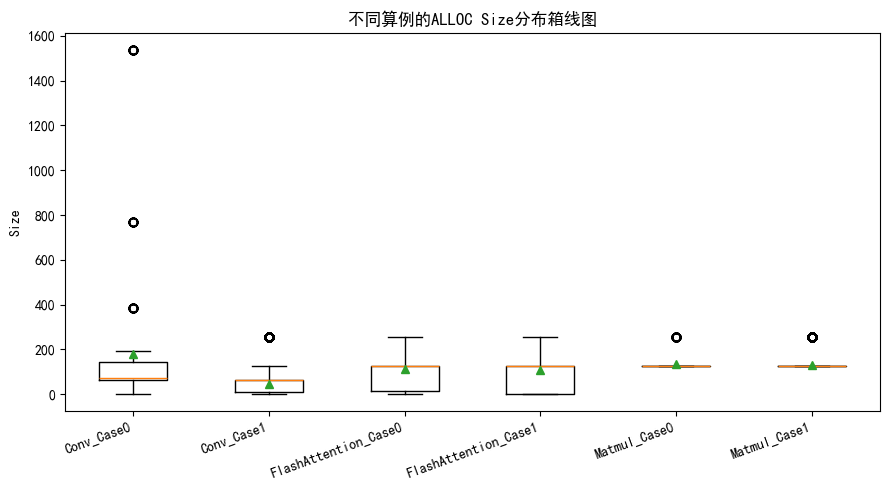

保存: ./plots_problem1_data\desc_plot_alloc_size_boxplot.png


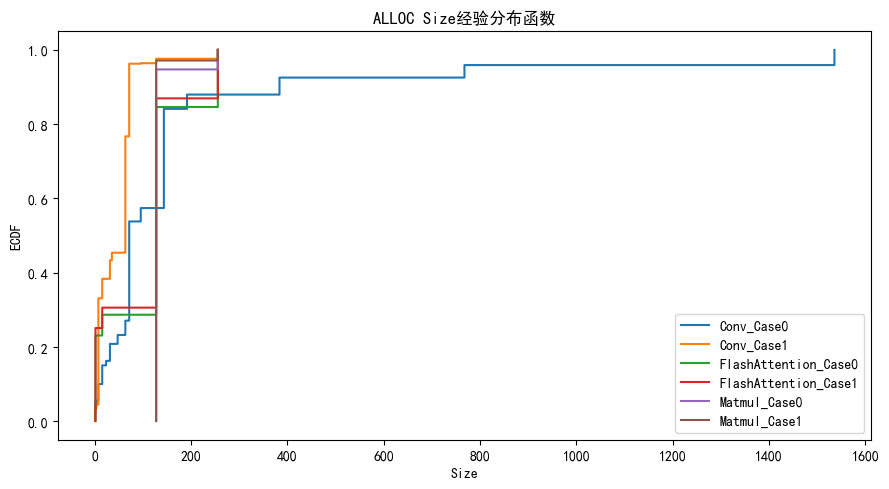

保存: ./plots_problem1_data\desc_plot_alloc_size_ecdf.png


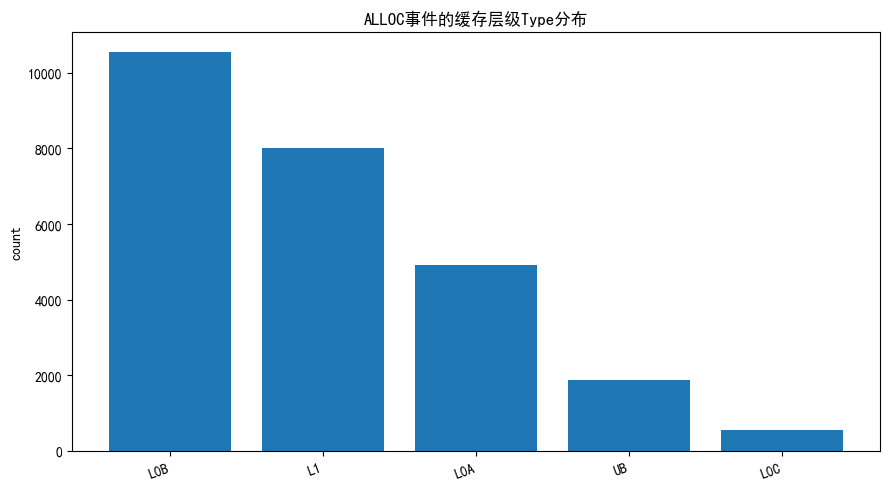

保存: ./plots_problem1_data\desc_plot_type_dist_alloc.png


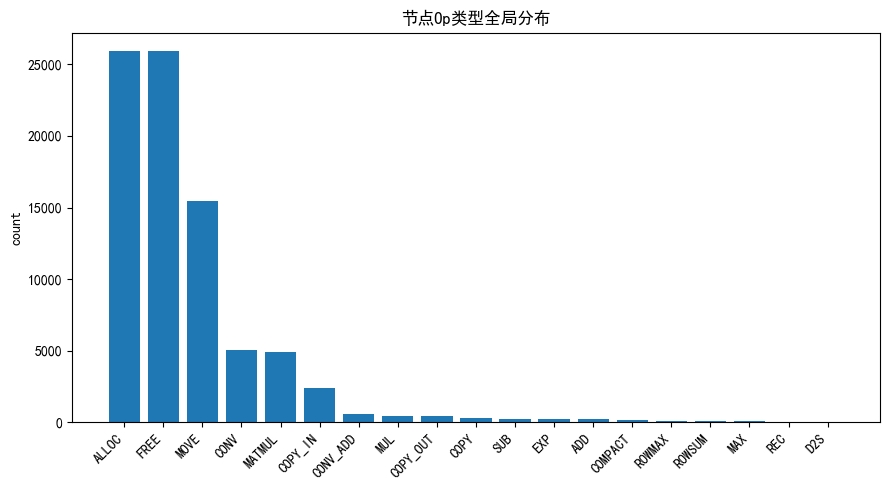

保存: ./plots_problem1_data\desc_plot_op_dist.png
完成。输出目录: D:\code\数学建模2025\重跑\plots_problem1_data


In [3]:
# -*- coding: utf-8 -*-
"""
问题1数据的描述性统计与可视化
- 自动发现 *_Nodes.csv 和 *_Edges.csv
- 生成6张图: 节点与边数量对比, ALLOC与FREE数量对比, ALLOC Size箱线图, ALLOC Size经验分布,
             ALLOC的Type分布, 全局Op分布
- 导出一张汇总表 problem1_data_summary.csv
"""

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========= 可配置项 =========
base_dir = "./CSV"                 # 放置12个CSV的目录, 例如 "./CSV" 或 "/mnt/data"
out_dir  = "./plots_problem1_data"  # 输出图片与表格的目录
SAVE_PDF = False               # 若为True, 同时另存PDF矢量图
# ==========================

# 尝试中文字体, 避免中文标题乱码
try:
    from matplotlib import rcParams
    rcParams["font.sans-serif"] = ["SimHei", "Arial Unicode MS", "Noto Sans CJK SC"]
    rcParams["axes.unicode_minus"] = False
except Exception:
    pass

os.makedirs(out_dir, exist_ok=True)

# 发现文件
node_files = sorted(glob.glob(os.path.join(base_dir, "*_Nodes.csv")))
edge_files = sorted(glob.glob(os.path.join(base_dir, "*_Edges.csv")))
assert len(node_files) == 6 and len(edge_files) == 6, "应在base_dir内找到6个*_Nodes.csv与6个*_Edges.csv"

def case_key_from_path(p):
    name = os.path.basename(p)
    return name.replace("_Nodes.csv", "").replace("_Edges.csv", "")

# 读取
cases = {}
for nf in node_files:
    key = case_key_from_path(nf)
    nodes = pd.read_csv(nf)
    cases.setdefault(key, {})["nodes"] = nodes

for ef in edge_files:
    key = case_key_from_path(ef)
    edges = pd.read_csv(ef)
    cases.setdefault(key, {})["edges"] = edges

# 汇总统计
summary_rows = []
alloc_size_by_case = {}
type_dist_all = []
op_dist_all = []

for key in sorted(cases.keys()):
    nodes = cases[key].get("nodes", pd.DataFrame())
    edges = cases[key].get("edges", pd.DataFrame())

    # 列名大小写兼容
    cols = {c.lower(): c for c in nodes.columns}
    op_col   = cols.get("op")
    buf_col  = cols.get("bufid")
    size_col = cols.get("size")
    type_col = cols.get("type")

    nodes_local = nodes.copy()
    if op_col is not None:
        nodes_local[op_col] = nodes_local[op_col].astype(str).str.upper()
    else:
        nodes_local["OP"] = "UNKNOWN"
        op_col = "OP"

    # 全局分布收集
    op_dist_all.append(nodes_local[op_col].value_counts())

    # 事件计数
    is_alloc = nodes_local[op_col] == "ALLOC"
    is_free  = nodes_local[op_col] == "FREE"

    unique_bufids = 0
    if buf_col is not None:
        buf_series = pd.concat([
            nodes_local.loc[is_alloc, buf_col],
            nodes_local.loc[is_free, buf_col]
        ], ignore_index=True).dropna()
        unique_bufids = buf_series.nunique()

    # ALLOC Size统计
    alloc_size_sum = None
    alloc_size_min = None
    alloc_size_max = None
    alloc_size_med = None
    alloc_size_p90 = None
    alloc_size_mean = None

    if size_col is not None:
        alloc_sizes = pd.to_numeric(nodes_local.loc[is_alloc, size_col], errors="coerce").dropna()
        if not alloc_sizes.empty:
            alloc_size_sum  = int(alloc_sizes.sum())
            alloc_size_min  = int(alloc_sizes.min())
            alloc_size_max  = int(alloc_sizes.max())
            alloc_size_med  = float(alloc_sizes.median())
            alloc_size_p90  = float(np.percentile(alloc_sizes, 90))
            alloc_size_mean = float(alloc_sizes.mean())
            alloc_size_by_case[key] = alloc_sizes.values

    # Type分布
    if type_col is not None:
        type_dist_all.append(nodes_local.loc[is_alloc, type_col].astype(str).value_counts())

    # 边计数
    edges_count = len(edges)

    summary_rows.append({
        "case": key,
        "nodes": len(nodes),
        "edges": edges_count,
        "alloc": int(is_alloc.sum()),
        "free": int(is_free.sum()),
        "unique_bufid": int(unique_bufids),
        "alloc_size_sum": alloc_size_sum,
        "alloc_size_min": alloc_size_min,
        "alloc_size_max": alloc_size_max,
        "alloc_size_median": None if alloc_size_med is None else round(alloc_size_med, 3),
        "alloc_size_p90": None if alloc_size_p90 is None else round(alloc_size_p90, 3),
        "alloc_size_mean": None if alloc_size_mean is None else round(alloc_size_mean, 3),
    })

summary_df = pd.DataFrame(summary_rows).sort_values("case").reset_index(drop=True)
summary_csv = os.path.join(out_dir, "problem1_data_summary.csv")
summary_df.to_csv(summary_csv, index=False)
print(f"汇总表已保存: {summary_csv}")
display(summary_df)

# ========== 图1: Nodes与Edges数量对比 ==========
plt.figure(figsize=(9, 5))
x = np.arange(len(summary_df))
width = 0.35
plt.bar(x - width/2, summary_df["nodes"], width, label="nodes")
plt.bar(x + width/2, summary_df["edges"], width, label="edges")
plt.xticks(x, summary_df["case"], rotation=20, ha="right")
plt.ylabel("count")
plt.title("Nodes与Edges数量对比")
plt.legend()
plt.tight_layout()
fig1_png = os.path.join(out_dir, "desc_plot_nodes_edges.png")
plt.savefig(fig1_png, dpi=150)
if SAVE_PDF:
    plt.savefig(os.path.join(out_dir, "desc_plot_nodes_edges.pdf"))
plt.show()
print(f"保存: {fig1_png}")

# ========== 图2: ALLOC与FREE数量对比 ==========
plt.figure(figsize=(9, 5))
plt.bar(x - width/2, summary_df["alloc"], width, label="alloc")
plt.bar(x + width/2, summary_df["free"], width, label="free")
plt.xticks(x, summary_df["case"], rotation=20, ha="right")
plt.ylabel("count")
plt.title("ALLOC与FREE事件数量对比")
plt.legend()
plt.tight_layout()
fig2_png = os.path.join(out_dir, "desc_plot_alloc_free.png")
plt.savefig(fig2_png, dpi=150)
if SAVE_PDF:
    plt.savefig(os.path.join(out_dir, "desc_plot_alloc_free.pdf"))
plt.show()
print(f"保存: {fig2_png}")

# ========== 图3: 不同算例的ALLOC Size箱线图 ==========
box_data = []
labels = []
for key in summary_df["case"]:
    arr = alloc_size_by_case.get(key, np.array([]))
    if arr.size > 0:
        box_data.append(arr)
        labels.append(key)

if box_data:
    plt.figure(figsize=(9, 5))
    plt.boxplot(box_data, labels=labels, showmeans=True)
    plt.xticks(rotation=20, ha="right")
    plt.ylabel("Size")
    plt.title("不同算例的ALLOC Size分布箱线图")
    plt.tight_layout()
    fig3_png = os.path.join(out_dir, "desc_plot_alloc_size_boxplot.png")
    plt.savefig(fig3_png, dpi=150)
    if SAVE_PDF:
        plt.savefig(os.path.join(out_dir, "desc_plot_alloc_size_boxplot.pdf"))
    plt.show()
    print(f"保存: {fig3_png}")
else:
    print("无ALLOC Size数据可绘制箱线图")

# ========== 图4: 各算例ALLOC Size经验分布函数 ==========
def ecdf(data):
    data = np.sort(np.asarray(data))
    y = np.arange(1, data.size + 1) / data.size
    return data, y

if box_data:
    plt.figure(figsize=(9, 5))
    for key in summary_df["case"]:
        arr = alloc_size_by_case.get(key, np.array([]))
        if arr.size > 0:
            x_vals, y_vals = ecdf(arr)
            plt.step(x_vals, y_vals, where="post", label=key)
    plt.xlabel("Size")
    plt.ylabel("ECDF")
    plt.title("ALLOC Size经验分布函数")
    plt.legend()
    plt.tight_layout()
    fig4_png = os.path.join(out_dir, "desc_plot_alloc_size_ecdf.png")
    plt.savefig(fig4_png, dpi=150)
    if SAVE_PDF:
        plt.savefig(os.path.join(out_dir, "desc_plot_alloc_size_ecdf.pdf"))
    plt.show()
    print(f"保存: {fig4_png}")
else:
    print("无ALLOC Size数据可绘制ECDF")

# ========== 图5: ALLOC的Type分布(全局) ==========
if type_dist_all:
    type_sum = pd.concat(type_dist_all, axis=1).fillna(0).sum(axis=1).sort_values(ascending=False)
    plt.figure(figsize=(9, 5))
    plt.bar(type_sum.index.astype(str), type_sum.values)
    plt.xticks(rotation=20, ha="right")
    plt.ylabel("count")
    plt.title("ALLOC事件的缓存层级Type分布")
    plt.tight_layout()
    fig5_png = os.path.join(out_dir, "desc_plot_type_dist_alloc.png")
    plt.savefig(fig5_png, dpi=150)
    if SAVE_PDF:
        plt.savefig(os.path.join(out_dir, "desc_plot_type_dist_alloc.pdf"))
    plt.show()
    print(f"保存: {fig5_png}")
else:
    print("未找到Type列或无ALLOC事件")

# ========== 图6: 全局Op分布 ==========
if op_dist_all:
    op_sum = pd.concat(op_dist_all, axis=1).fillna(0).sum(axis=1).sort_values(ascending=False)
    plt.figure(figsize=(9, 5))
    plt.bar(op_sum.index.astype(str), op_sum.values)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("count")
    plt.title("节点Op类型全局分布")
    plt.tight_layout()
    fig6_png = os.path.join(out_dir, "desc_plot_op_dist.png")
    plt.savefig(fig6_png, dpi=150)
    if SAVE_PDF:
        plt.savefig(os.path.join(out_dir, "desc_plot_op_dist.pdf"))
    plt.show()
    print(f"保存: {fig6_png}")
else:
    print("未找到Op列")

print("完成。输出目录:", os.path.abspath(out_dir))


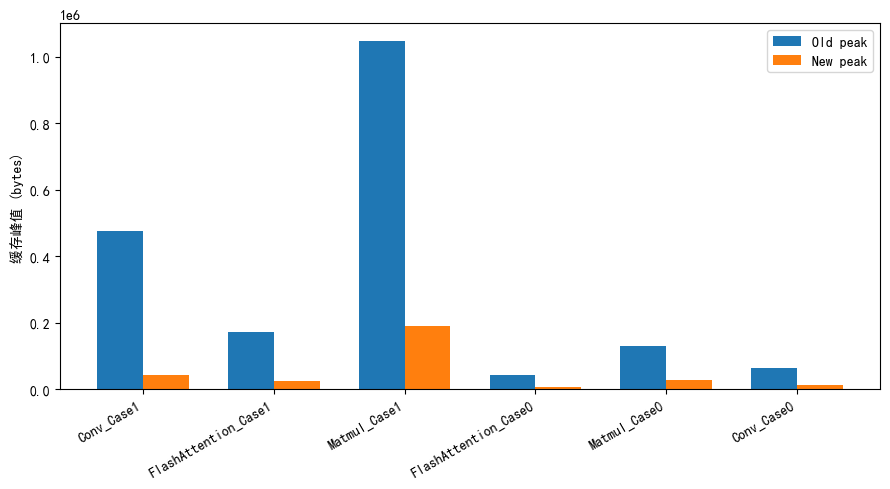

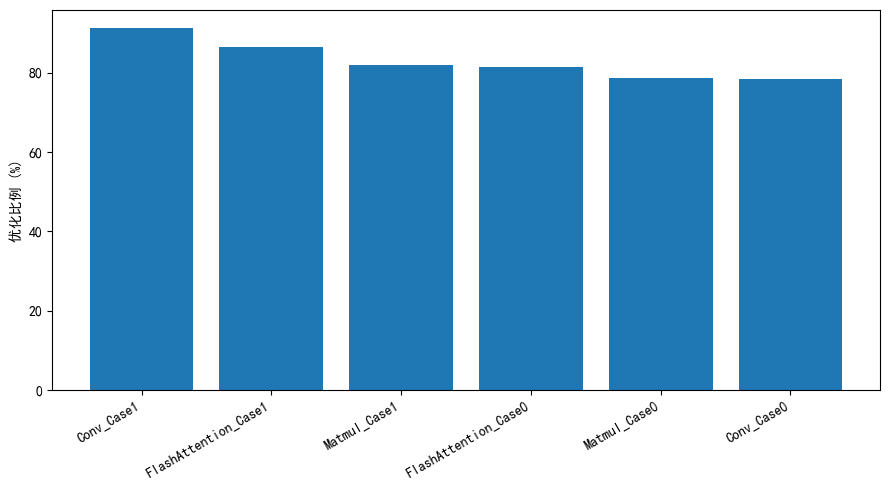

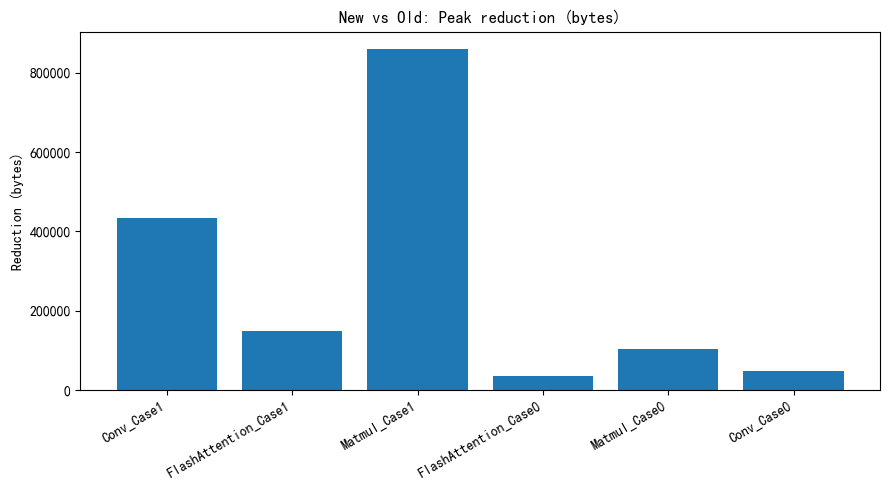

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from matplotlib import rcParams
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False

# Paths
old_path = Path("./Problem1/Problem1_eval_summary.csv")
new_path = Path("./A1/所有案例调度结果汇总.csv")

# Load
old = pd.read_csv(old_path)
new = pd.read_csv(new_path)

# Standardize case columns
old["case"] = old["task"].astype(str).str.strip()
new["case"] = new["案例名"].astype(str).str.strip()

# Select needed columns
old_sub = old[["case","peak_user"]].rename(columns={"peak_user":"peak_old"})
new_sub = new[["case","最大缓存驻留容量"]].rename(columns={"最大缓存驻留容量":"peak_new"})

# Merge
cmp = pd.merge(old_sub, new_sub, on="case", how="inner")
cmp["reduction_bytes"] = (cmp["peak_old"] - cmp["peak_new"]).astype(int)
cmp["reduction_pct"] = np.where(cmp["peak_old"]>0, (cmp["reduction_bytes"]/cmp["peak_old"])*100.0, np.nan)

# Order by reduction_pct desc
cmp = cmp.sort_values("reduction_pct", ascending=False).reset_index(drop=True)

# Save table
out_csv = "./old_vs_new_peak_comparison.csv"
cmp.to_csv(out_csv, index=False)

# Plot 1: side-by-side peaks
plt.figure(figsize=(9,5))
x = np.arange(len(cmp))
w = 0.35
plt.bar(x - w/2, cmp["peak_old"].values, width=w, label="Old peak")
plt.bar(x + w/2, cmp["peak_new"].values, width=w, label="New peak")
plt.xticks(x, cmp["case"].tolist(), rotation=30, ha="right")
plt.ylabel("缓存峰值 (bytes)")
plt.title("")
plt.legend()
plt.tight_layout()
p1 = "./plot_peak_old_vs_new.png"
plt.savefig(p1, dpi=220)
plt.show()

# Plot 2: reduction percent
plt.figure(figsize=(9,5))
plt.bar(cmp["case"].tolist(), cmp["reduction_pct"].values)
plt.xticks(rotation=30, ha="right")
plt.ylabel("优化比例 (%)")
plt.title("")
plt.tight_layout()
p2 = "./plot_peak_reduction_pct.png"
plt.savefig(p2, dpi=220)
plt.show()

# Plot 3: reduction bytes
plt.figure(figsize=(9,5))
plt.bar(cmp["case"].tolist(), cmp["reduction_bytes"].values)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Reduction (bytes)")
plt.title("New vs Old: Peak reduction (bytes)")
plt.tight_layout()
p3 = "./plot_peak_reduction_bytes.png"
plt.savefig(p3, dpi=220)
plt.show()